<a href="https://colab.research.google.com/github/146790g/BreakHis-VGG16/blob/master/BreakHis_VGG16_8_patients_clustering_via_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深層学習 VGG16モデルを用いた乳がん染色画像（BreakHis）の解析
#（その８: 特徴量に基づく主成分分析による乳がん患者のセグメンテーション ）
# Deep Learning for Magnification Independent Breast Cancer Histopathology

<br>

# Breast Cancer Patietns Segementation using VGG16 model in frame of k-means methods

<br>


<h2>対象データは、こちらをクリック ☞　</>
<a href='https://www.kaggle.com/ambarish/breakhis'>Kaggle BreakHis Data</a>

４つのMagnification levelのデータをすべて合算して、解析する

<br>

## 4 Magnification Levels: ×40, ×100, ×200, ×400


During analysis and annotation, pathologists starts by identifying ROIs in
the lowest magnification level slide (×40), then dives deeper in the latter using higher magnification levels (×100, ×200) until having a profound insight
(×400). 

<br>

## データ数 の概要

・Training Data: 5026 images <br>
  -- Benign Data: 1472 images <br>
  -- Mallignant Data: 3554 images 

・Validation Data: 2904 images <br>
  -- Benign Data: 1008 images <br>
  -- Mallignant Data:1896 images <br>

## Data Set Details by Magnification levels.

 ×40 : <br>
×100 : <br>
×200 : <br>
×400 : <br>

In [ ]:
%tensorflow_version 2.x

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls -lh '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data'

total 8.0K
drwx------ 2 root root 4.0K Jul 21 03:42 train
drwx------ 2 root root 4.0K Jul 27 01:49 validation


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import MeanShift, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import mixture
from sklearn.cluster import MeanShift, estimate_bandwidth
import pickle
import pandas as pd
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import os
#import Pillow
#from PIL import Image
#import opencv
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
import numpy as np
from keras.models import load_model

    


# 第１０章 特徴データに基づく乳がん患者のセグメンテーション


### 乳癌患者のみの特徴量データを読み込む
### 乳がん患者の画像データは、全部で、３５５４＋１８９６＝５４５０枚ある。

## Step1: テストデータのうち、乳癌組織の画像データを4階のテンソルの配列データに変換する

In [ ]:
train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/train' # 訓練データのフォルダー
validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/validation' # テストデータのフォルダー
result_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/results'        # VGG19の出力結果を保存するフォルダー
test_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/test'
    

files=os.listdir(os.path.join(test_dir,'malignant'))

test_img_array_list = []

for img in files:
  
    file=os.path.join(test_dir,'malignant', img)
    temp_img = load_img(file,target_size=(400,400))

    #PIL形式からNumpy配列に変換と正規化(400, 400, 3)
    temp_img_array = img_to_array(temp_img) /255

    #変換したNumpy配列を末尾に追加
    test_img_array_list.append(temp_img_array)

    
import numpy as np


test_malignant = np.array(test_img_array_list)

print(type(test_malignant))
print(test_malignant.shape)




<class 'numpy.ndarray'>
(94, 400, 400, 3)


##Step2 : 構築したモデルに基づいて、乳癌患者の画像データの特徴量を抽出する（94例）

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
import numpy as np
from keras.models import load_model

model=load_model(os.path.join(result_dir,'breakhis_vgg16model_parameter.h5'))

layer_outputs = model.get_layer('dense').output

model2 = models.Model(inputs=model.input, outputs=layer_outputs)



#乳癌組織の特徴量データ
feature_malignant=model2.predict(test_malignant)


print(feature_malignant.shape)
print(type(feature_malignant))

dat=pd.DataFrame(feature_malignant)

dat.head()

(94, 256)
<class 'numpy.ndarray'>


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0.925978,0.000000,0.0,0.052348,0.00000,0.012440,0.723832,0.344564,0.000000,0.000000,0.0,0.0,0.090099,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.958451,0.000000,0.0,0.000000,0.000000,0.569055,0.0,0.0,0.000000,0.000000,0.949395,0.0,0.000000,0.709232,0.0,0.0,0.000000,0.694359,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.099944,0.0,0.0,0.0,0.000000,1.808554,0.0,0.0,0.000000,1.091249,0.053755,0.000000,0.0,0.000000,0.246003,0.000000,0.0,0.937355,0.000000,0.391252,0.0,0.0,0.0,0.000000,0.0,1.752473,0.000000,0.000000,0.631917,1.037877,0.0,0.0,0.0,0.0
1,1.196234,0.000000,0.0,0.000000,0.00000,0.082081,1.445180,0.962895,0.000000,0.000000,0.0,0.0,0.706407,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.484302,0.000000,0.0,0.000000,0.000000,1.183024,0.0,0.0,0.000000,0.403432,1.520885,0.0,0.000000,0.726557,0.0,0.0,0.000000,0.784326,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.709905,0.0,0.0,0.0,0.217439,2.237989,0.0,0.0,0.000000,1.577627,0.000000,0.000000,0.0,0.000000,0.663574,0.000000,0.0,1.443799,0.000000,1.194020,0.0,0.0,0.0,0.000000,0.0,1.692829,0.000000,0.000000,1.049251,1.582560,0.0,0.0,0.0,0.0
2,3.968085,2.820742,0.0,0.000000,0.00000,0.000000,3.297671,3.893893,0.000000,2.271101,0.0,0.0,3.734821,0.0,0.0,0.0,0.0,0.768182,0.0,0.000000,4.198579,0.821071,0.0,3.781477,2.400937,4.342148,0.0,0.0,0.000000,4.807205,3.977953,0.0,2.109443,0.000000,0.0,0.0,2.242552,4.347653,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,4.290143,0.0,0.0,0.0,0.000000,4.041382,0.0,0.0,2.149379,4.683289,0.000000,1.606997,0.0,0.000000,3.263248,3.391760,0.0,3.795064,0.000000,3.937660,0.0,0.0,0.0,0.165275,0.0,3.353735,0.000000,0.000000,3.592703,4.132342,0.0,0.0,0.0,0.0
3,1.009994,0.000000,0.0,0.045644,0.00000,0.328428,1.111528,0.574569,0.000000,0.000000,0.0,0.0,0.535727,0.0,0.0,0.0,0.0,0.000000,0.0,0.117734,1.291100,0.000000,0.0,0.000000,0.000000,0.731065,0.0,0.0,0.157339,0.359369,1.092721,0.0,0.000000,0.570623,0.0,0.0,0.000000,0.588758,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.431107,0.0,0.0,0.0,0.000000,2.102942,0.0,0.0,0.000000,1.268014,0.267612,0.000000,0.0,0.000000,0.391476,0.000000,0.0,1.062971,0.140407,1.029258,0.0,0.0,0.0,0.000000,0.0,1.783471,0.019453,0.000000,0.755849,0.868596,0.0,0.0,0.0,0.0
4,2.000358,0.675378,0.0,0.000000,0.06668,0.126261,1.908052,1.745808,0.135832,0.752969,0.0,0.0,1.416198,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,2.339535,0.000000,0.0,1.380153,0.000000,1.890557,0.0,0.0,0.162332,2.132661,1.863910,0.0,0.000000,0.105113,0.0,0.0,0.038101,1.674470,0.0,0.041385,...,0.0,0.0,0.0,0.029553,0.0,0.0,2.632069,0.0,0.0,0.0,0.000000,2.738144,0.0,0.0,0.493369,2.309583,0.000000,0.000000,0.0,0.015207,1.506454,1.229448,0.0,2.086471,0.000000,1.728053,0.0,0.0,0.0,0.000000,0.0,2.219107,0.000000,0.053765,1.772939,2.574878,0.0,0.0,0.0,0.0


## Step3: 特徴量データに対して、主成分分析を行い、それらの主成分に基づいてスケーリング、k-means法による患者分類を行う。分類数は、４とする。
## 主成分分析では、第５主成分までを算出する。

In [ ]:
pca=PCA(n_components=5)

pipe_km = Pipeline([("scaler", StandardScaler()), 
                    ('pca',PCA(n_components=5)),
                    ("kmeans", KMeans(n_clusters=4))])

pcax = pca.fit_transform(dat)

print(pcax[:3])

[[-1.2279498e+01 -3.8791364e-01  1.0492013e+00 -2.1403580e+00
  -1.2134510e+00]
 [-9.1038532e+00 -1.5958192e+00  9.0568477e-01 -8.7272662e-01
  -3.2439324e-01]
 [ 1.7326271e+01  1.5609685e+00 -2.2066813e+00 -4.2449805e-01
   1.1313303e-02]]


## 第１主成分　VS 　第2主成分の　プロット

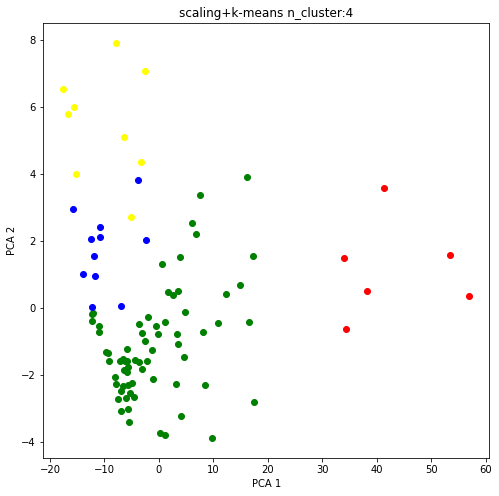

In [ ]:
p_km_y = pipe_km.fit_predict(dat)

y=p_km_y
name="scaling+k-means"
n_cluster=4
i=1

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

colors=['red','green','yellow','blue','black']

for target in range(n_cluster):
    axes.scatter(pcax[y==target,0],pcax[y==target,1],c=colors[target])
    axes.set_title("{0} n_cluster:{1}".format(name, n_cluster))
    axes.set_xlabel('PCA 1')
    axes.set_ylabel('PCA 2')




## 第１主成分　VS 　第３主成分の　プロット

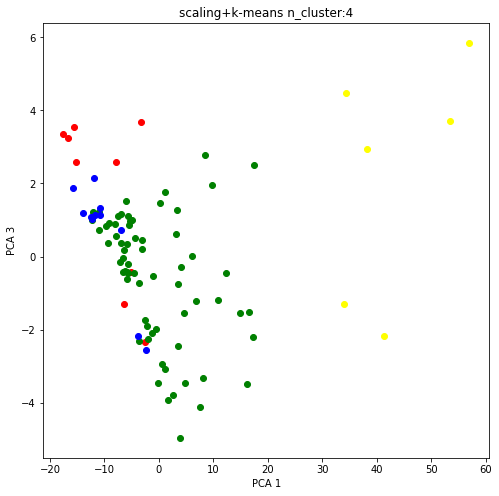

In [ ]:
p_km_y = pipe_km.fit_predict(dat)

y=p_km_y
name="scaling+k-means"
n_cluster=4
i=1

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

colors=['red','green','yellow','blue','black']

for target in range(n_cluster):
    axes.scatter(pcax[y==target,0],pcax[y==target,2],c=colors[target])
    axes.set_title("{0} n_cluster:{1}".format(name, n_cluster))
    axes.set_xlabel('PCA 1')
    axes.set_ylabel('PCA 3')

## 第１主成分　VS 　第４主成分の　プロット

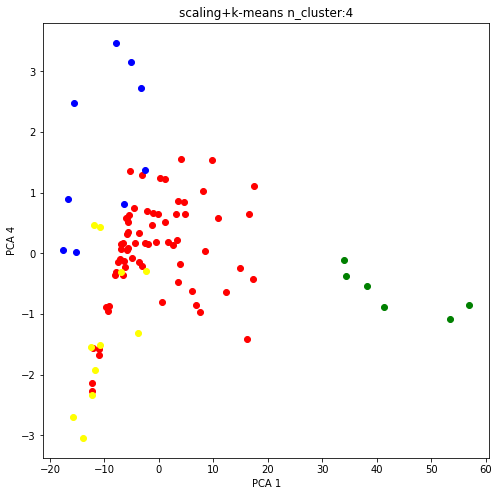

In [ ]:
p_km_y = pipe_km.fit_predict(dat)

y=p_km_y
name="scaling+k-means"
n_cluster=4
i=1

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

colors=['red','green','yellow','blue','black']

for target in range(n_cluster):
    axes.scatter(pcax[y==target,0],pcax[y==target,3],c=colors[target])
    axes.set_title("{0} n_cluster:{1}".format(name, n_cluster))
    axes.set_xlabel('PCA 1')
    axes.set_ylabel('PCA 4')

## 第１主成分　VS 　第５主成分の　プロット

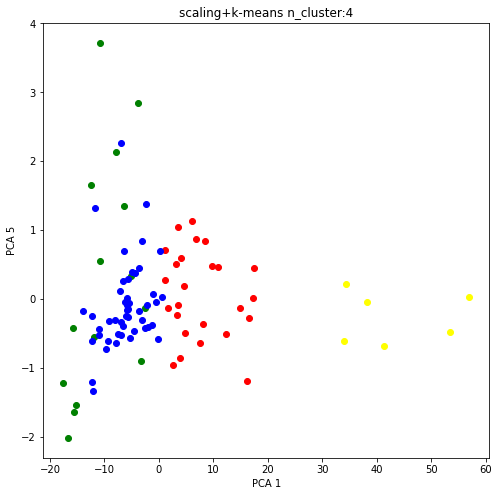

In [ ]:
p_km_y = pipe_km.fit_predict(dat)

y=p_km_y
name="scaling+k-means"
n_cluster=4
i=1

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

colors=['red','green','yellow','blue','black']

for target in range(n_cluster):
    axes.scatter(pcax[y==target,0],pcax[y==target,4],c=colors[target])
    axes.set_title("{0} n_cluster:{1}".format(name, n_cluster))
    axes.set_xlabel('PCA 1')
    axes.set_ylabel('PCA 5')

# 【考察】

##特徴量データに基づいて、クラスタリングを行った。スケーリングの前処理を行い、次に、k-means法によって分類する方法が、もっとも、真値に近いことが示された。また、このクラスタリングにより、VGG16モデルによる特徴量の抽出が適切にできていることが示された。